<a href="https://colab.research.google.com/github/patricksabry1/42028-Deep-Learning/blob/master/Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Image classification - 17 Flowers dataset

The baseline architecture used will be the vgg16 architecture. The original vgg16 architecture will be experimented with first, and then transfer learning will be used to adapt the pre-trained vgg16 model to the flower data. The results of both models will be evaluated and compared for accuracy and training time.


## Data pre-processing

### Initialise dependencies & mount g drive for data extraction

In [1]:
%pip install livelossplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKerasTF
from tqdm import tqdm
from skimage import feature
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
import cv2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [14]:
cd /content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2/

/content/gdrive/My Drive/42028-DL-CNN-2020/assignment-2


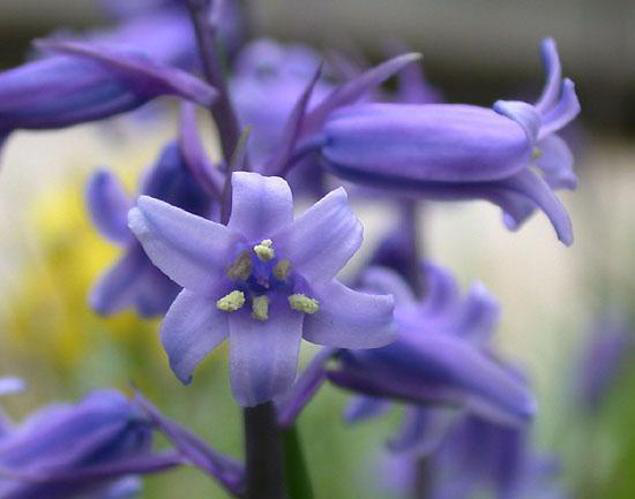

In [15]:
from PIL import Image #show one example of image
Image.open("../assignment-2/17FlowerDataset/Bluebell/image_0241.jpg")

In [0]:
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')

    return img

In [33]:
import os

# Load images as np arrays to be saved again as images later on when split into train and test subsets.
rootdir = '../assignment-2/17FlowerDataset/'
images=[]
labels=[]
total=1361
j=1
i=0
class_dict = {}
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        images.append(load_data(os.path.join(subdir, file)))
        labels.append(j) #labels are created as well
        class_dict[j] = str(subdir)
        i += 1
        if i % 80 == 0: j += 1

class_key_map = {}
for key, value in class_dict.items():
    if value not in class_key_map.values():
        val = value.split("/")[-1] 
        class_key_map[key] = val

print(class_key_map)

stored 0 image
stored 1 image
stored 2 image
stored 3 image
stored 4 image
stored 5 image
stored 6 image
stored 7 image
stored 8 image
stored 9 image
stored 10 image
stored 11 image
stored 12 image
stored 13 image
stored 14 image
stored 15 image
stored 16 image
stored 17 image
stored 18 image
stored 19 image
stored 20 image
stored 21 image
stored 22 image
stored 23 image
stored 24 image
stored 25 image
stored 26 image
stored 27 image
stored 28 image
stored 29 image
stored 30 image
stored 31 image
stored 32 image
stored 33 image
stored 34 image
stored 35 image
stored 36 image
stored 37 image
stored 38 image
stored 39 image
stored 40 image
stored 41 image
stored 42 image
stored 43 image
stored 44 image
stored 45 image
stored 46 image
stored 47 image
stored 48 image
stored 49 image
stored 50 image
stored 51 image
stored 52 image
stored 53 image
stored 54 image
stored 55 image
stored 56 image
stored 57 image
stored 58 image
stored 59 image
stored 60 image
stored 61 image
stored 62 image
st

In [22]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

In [0]:
# Split data into training and test. Since this is a very small dataset, a 70/30 split was deemed best to avoid overfitting.
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size = 0.7, random_state =  104)

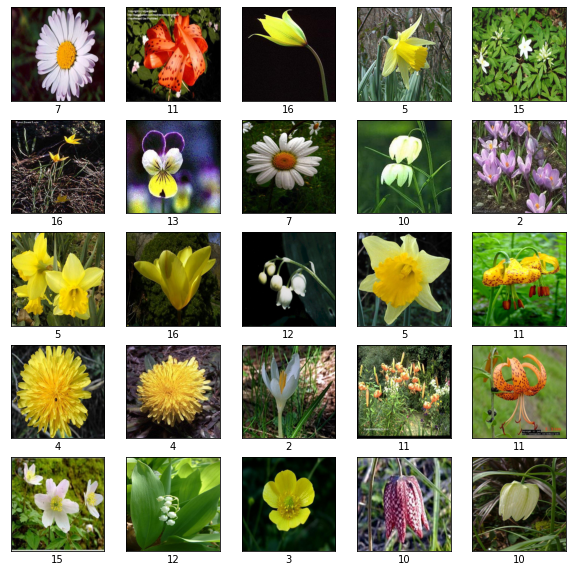

In [37]:
# plot some sample images with corresponding labels to verify image labelling.
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i]/255, cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [0]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
      os.mkdir(dirname)
    n=0
    
    for i in data:
      label_n=labels[n]
      subfolder = folder + "/" + str(label_n) 
      if not os.path.exists(subfolder): # create subfolders with categories
          os.mkdir(subfolder)  
      filepath =  subfolder + "/" + str(n)+ ".jpg"
      cv2.imwrite(filepath, data[n]) #save image to corresponding subfolders
      n+=1

create_images(X_train, y_train, 'train') #save image to corresponding subfolders
create_images(X_test, y_test, 'test')
train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')
image_size = 224

Fit Flower data onto baseline vgg16 model

In [0]:
import tensorflow as tf
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.layers import Input, Dense

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Custom Object Detection

## Data Pre-processing

In [0]:
def load_flowers(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load Flower data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels